### Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## 1. Выбор начальных условий

# Набор данных

Данные https://www.kaggle.com/datasets/artemgoncarov/animals-segmentation-and-detection
Этот датасет также подходит для ЛР8

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas

Train loaded: 500 samples
Val   loaded: 100 samples


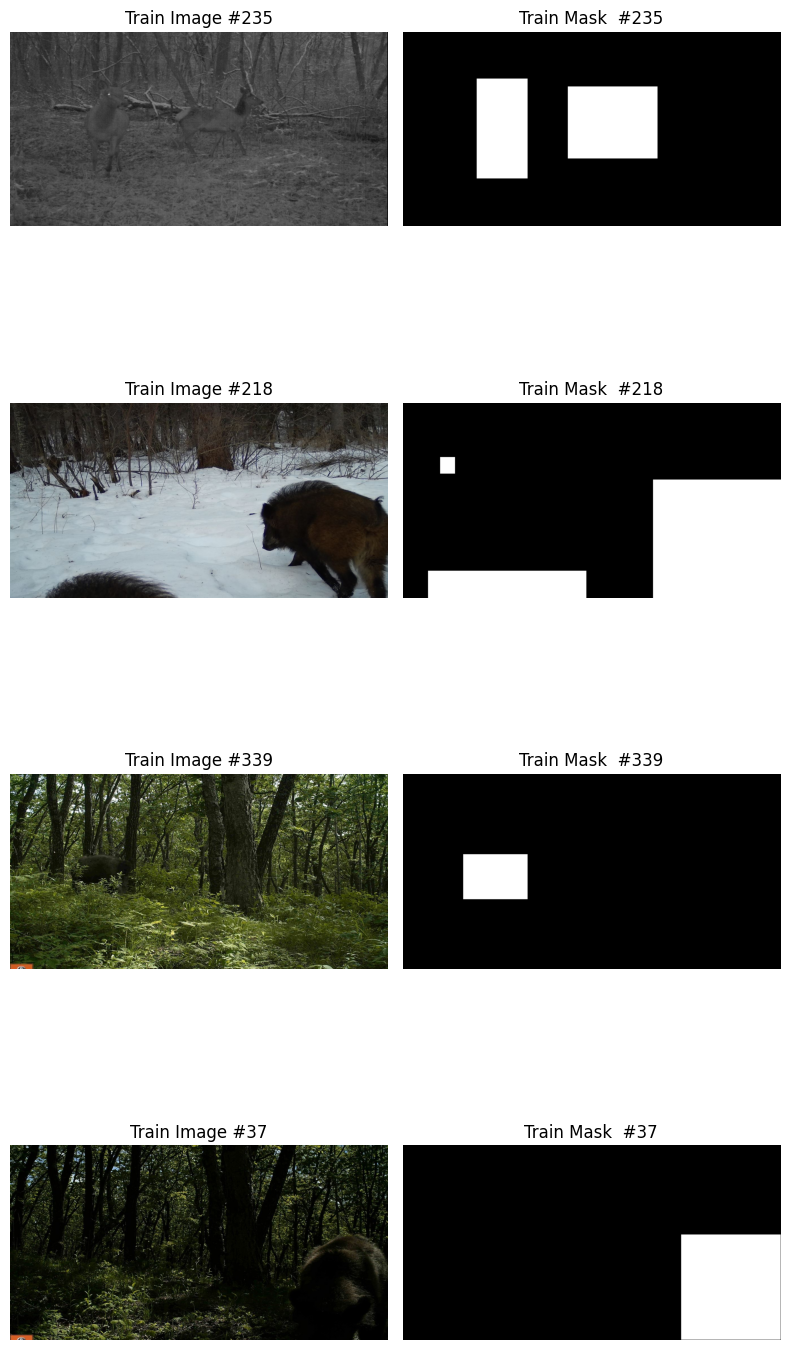

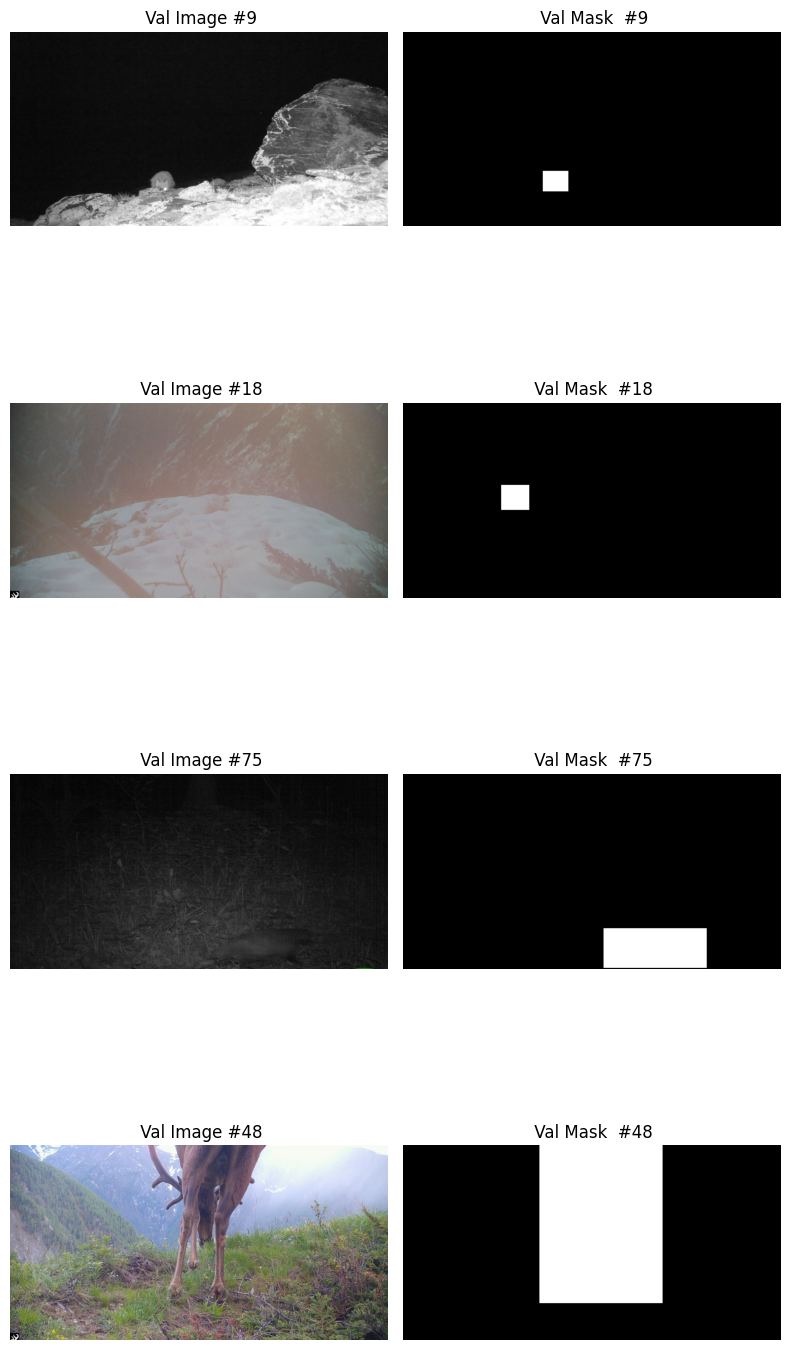

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

BASE = "C:/Users/Anna/Downloads/multi_sem2/animals-segmentation-and-detection/data"

TRAIN_IMG_DIR = os.path.join(BASE, "train/images")
TRAIN_LBL_DIR = os.path.join(BASE, "train/labels")
VAL_IMG_DIR   = os.path.join(BASE, "val/images")
VAL_LBL_DIR   = os.path.join(BASE, "val/labels")

def load_subset(img_dir, lbl_dir, max_files):
    """Загружает до max_files параллельно картинку+маску."""
    image_data, image_masks = [], []
    files = [f for f in sorted(os.listdir(img_dir))
             if f.lower().endswith(('.jpg','jpeg','png'))][:max_files]

    for fname in files:
        img = read_image(os.path.join(img_dir, fname)).float() / 255.0
        _, H, W = img.shape
        image_data.append(img)

        mask = torch.zeros((H, W), dtype=torch.uint8)

        txt = os.path.join(lbl_dir, fname.rsplit('.',1)[0] + ".txt")
        if os.path.exists(txt):
            with open(txt, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        _, xc, yc, w_rel, h_rel = parts[:5]
                        xc, yc, w_rel, h_rel = map(float, (xc, yc, w_rel, h_rel))
                        x_min = int((xc - w_rel/2) * W)
                        x_max = int((xc + w_rel/2) * W)
                        y_min = int((yc - h_rel/2) * H)
                        y_max = int((yc + h_rel/2) * H)
                        mask[y_min:y_max, x_min:x_max] = 1

        image_masks.append(mask)
    return image_data, image_masks

train_imgs, train_masks = load_subset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, max_files=500)
val_imgs,   val_masks   = load_subset(VAL_IMG_DIR,   VAL_LBL_DIR,   max_files=100)

print(f"Train loaded: {len(train_imgs)} samples")
print(f"Val   loaded: {len(val_imgs)} samples")

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
idxs = np.random.choice(len(train_imgs), size=4, replace=False)
for row, idx in enumerate(idxs):
    axes[row,0].imshow(train_imgs[idx].permute(1,2,0))
    axes[row,0].set_title(f"Train Image #{idx}")
    axes[row,0].axis("off")

    axes[row,1].imshow(train_masks[idx], cmap="gray")
    axes[row,1].set_title(f"Train Mask  #{idx}")
    axes[row,1].axis("off")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
idxs = np.random.choice(len(val_imgs), size=4, replace=False)
for row, idx in enumerate(idxs):
    axes[row,0].imshow(val_imgs[idx].permute(1,2,0))
    axes[row,0].set_title(f" Val Image #{idx}")
    axes[row,0].axis("off")

    axes[row,1].imshow(val_masks[idx], cmap="gray")
    axes[row,1].set_title(f" Val Mask  #{idx}")
    axes[row,1].axis("off")

plt.tight_layout()
plt.show()



# Метрики качества
Mean Average Precision (mAP)  
Это ключевая метрика для задач детекции объектов. Она отражает среднее значение точности (AP) по всем классам. В случае использования одного класса (например, животных), mAP позволяет оценить, насколько хорошо модель определяет наличие и расположение объектов на изображениях.  

Precision и Recall  
Precision показывает долю правильных предсказаний среди всех срабатываний модели, а Recall — насколько полно модель находит все объекты. Эти метрики особенно важны в задачах, где необходимо одновременно избегать ложных тревог и не пропускать настоящие объекты — например, в системах мониторинга или безопасности.  

## Создание бейзлана и оценка качества

в качестве базовых моделей будем использовать  YOLOv8 YOLOv11

In [3]:
!pip install ultralytics

     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.0 MB 991.0 kB/s eta 0:00:01
     -- ------------------------------------- 0.1/1.0 MB 1.3 MB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.0 MB 1.6 MB/s eta 0:00:01
     ---------------- ----------------------- 0.4/1.0 MB 2.8 MB/s eta 0:00:01
     -------------------------- ------------- 0.7/1.0 MB 3.3 MB/s eta 0:00:01
     ------------------------------------ --- 0.9/1.0 MB 3.6 MB/s eta 0:00:01
     ---------------------------------------  1.0/1.0 MB 3.3 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/39.5 MB 2.2 MB/s eta 0:00:19
     ---------------------------------------- 0.3/39.5 MB 3.2 MB/s eta 0:00:13
 


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import shutil
import yaml
from ultralytics import YOLO

ROOT        = r"C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data"
SRC_TR_IMG  = os.path.join(ROOT, "train", "images")
SRC_TR_LBL  = os.path.join(ROOT, "train", "labels")
SRC_VL_IMG  = os.path.join(ROOT, "val",   "images")
SRC_VL_LBL  = os.path.join(ROOT, "val",   "labels")

DST_BASE    = os.path.join(ROOT, "dataset")
for sub in ["train/images","train/labels","val/images","val/labels"]:
    d = os.path.join(DST_BASE, sub)
    if os.path.isdir(d): shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

def copy_first(src_img, src_lbl, dst_img, dst_lbl, n):
    files = sorted([f for f in os.listdir(src_img) if f.lower().endswith((".jpg",".jpeg",".png"))])
    for fn in files[:n]:
        shutil.copy(os.path.join(src_img, fn), os.path.join(dst_img, fn))
        lbl = os.path.splitext(fn)[0] + ".txt"
        shutil.copy(os.path.join(src_lbl, lbl), os.path.join(dst_lbl, lbl))

copy_first(SRC_TR_IMG, SRC_TR_LBL,
           os.path.join(DST_BASE, "train", "images"),
           os.path.join(DST_BASE, "train", "labels"),
           500)
copy_first(SRC_VL_IMG, SRC_VL_LBL,
           os.path.join(DST_BASE, "val", "images"),
           os.path.join(DST_BASE, "val", "labels"),
           100)


In [7]:
def prune_empty(img_dir, lbl_dir):
    for lbl in os.listdir(lbl_dir):
        path = os.path.join(lbl_dir, lbl)
        if os.path.getsize(path) == 0:
            os.remove(path)
            base = os.path.splitext(lbl)[0]
            for ext in (".jpg",".jpeg",".png"):
                p = os.path.join(img_dir, base+ext)
                if os.path.exists(p):
                    os.remove(p)

prune_empty(os.path.join(DST_BASE,"train","images"), os.path.join(DST_BASE,"train","labels"))
prune_empty(os.path.join(DST_BASE,"val","images"),   os.path.join(DST_BASE,"val","labels"))

assert len(os.listdir(os.path.join(DST_BASE,"train","images"))) > 0, "Train/images пусто!"
assert len(os.listdir(os.path.join(DST_BASE,"val","images")))   > 0, "Val/images пусто!"

dataset_yaml = {
    'path': DST_BASE,
    'train': 'train/images',
    'val':   'val/images',
    'nc':    1,
    'names': ['animal']
}
yaml_path = os.path.join(DST_BASE, "animals_dataset.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False, sort_keys=False)
print("YAML saved to", yaml_path)
print(open(yaml_path).read())




YAML saved to C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\animals_dataset.yaml
path: C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset
train: train/images
val: val/images
nc: 1
names:
- animal



In [4]:
model = YOLO("yolov8n.pt") 
results = model.train(data=yaml_path,
                      epochs=30,
                      imgsz=640,
                      batch=16) 


metrics = results.val(iou=0.5)
print(f"Precision: {metrics.box.p:.4f}")
print(f"Recall:    {metrics.box.r:.4f}")
print(f"mAP@0.5:   {metrics.box.map50:.4f}")
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")

Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\animals_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\train\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 15.67.9 MB/s, size: 166.7 KB)


val: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.03G      1.608       2.74      1.725         13        640: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

                   all        100        113      0.107      0.628      0.245      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.05G      1.669      2.464      1.717         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

                   all        100        113      0.192     0.0177     0.0766     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.07G      1.736      2.413      1.755          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.24it/s]


                   all        100        113      0.207      0.204      0.126     0.0419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.09G      1.782      2.346      1.787         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


                   all        100        113     0.0475      0.336     0.0508     0.0157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.11G      1.698      2.235       1.74          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

                   all        100        113      0.353      0.363      0.341       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.13G       1.76      2.147      1.745         15        640: 100%|██████████| 32/32 [00:03<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


                   all        100        113       0.31      0.301      0.223     0.0949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.14G      1.807      2.165      1.763         16        640: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.50it/s]

                   all        100        113      0.534      0.355      0.398       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.16G      1.699      2.083      1.706          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]

                   all        100        113      0.424      0.416      0.375      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.16G      1.694       2.03      1.701         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.38it/s]

                   all        100        113      0.601      0.347      0.396      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.16G      1.597      1.924      1.625         15        640: 100%|██████████| 32/32 [00:03<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]

                   all        100        113      0.468      0.442      0.413      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.16G      1.602      1.895      1.636          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]

                   all        100        113      0.615      0.496      0.528      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.16G       1.45       1.79      1.535         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.93it/s]

                   all        100        113      0.556      0.451      0.511      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.16G      1.487      1.765      1.536         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

                   all        100        113      0.487      0.336      0.374      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.16G       1.55      1.796        1.6         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

                   all        100        113      0.653      0.434      0.529      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.16G      1.489      1.761      1.539         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]

                   all        100        113      0.579        0.5      0.539       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.18G      1.458      1.759      1.528          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

                   all        100        113       0.63      0.434      0.525      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.19G      1.456      1.687      1.507         12        640: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]

                   all        100        113      0.602      0.442      0.512      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.21G       1.43      1.741      1.538         10        640: 100%|██████████| 32/32 [00:03<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

                   all        100        113      0.584      0.487      0.573      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.23G      1.396      1.668      1.483         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

                   all        100        113      0.546      0.649      0.581      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.24G      1.322      1.583      1.458         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

                   all        100        113      0.467      0.566      0.502      0.297


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.26G      1.387      1.717      1.571          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

                   all        100        113       0.53      0.566      0.548      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.26G      1.357      1.627      1.569          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]

                   all        100        113      0.527      0.628      0.603      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.26G      1.349      1.585      1.549          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.50it/s]

                   all        100        113      0.554      0.593      0.615      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.26G      1.257      1.509      1.479          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

                   all        100        113      0.667      0.566      0.673      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.26G      1.275       1.46      1.528          3        640: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.44it/s]


                   all        100        113      0.769      0.611      0.712      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.26G      1.245       1.41      1.446          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

                   all        100        113      0.653      0.602      0.664        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.26G      1.205       1.34      1.436          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

                   all        100        113      0.804      0.618      0.714      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.26G      1.167      1.379      1.413          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.89it/s]

                   all        100        113      0.658      0.612       0.68      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.26G      1.152      1.355      1.409          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.00it/s]

                   all        100        113      0.525      0.705      0.635      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.26G      1.106      1.334      1.386          5        640: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

                   all        100        113       0.52      0.717      0.639      0.399



30 epochs completed in 0.041 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 6.2MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


                   all        100        113      0.658      0.612      0.679      0.435
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train8


AttributeError: 'DetMetrics' object has no attribute 'val'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [8]:
model = YOLO("yolo11n.pt") 
results = model.train(data=yaml_path,
                      epochs=30,
                      imgsz=640,
                      batch=16) 


metrics = results.val(iou=0.5)
print(f"Precision: {metrics.box.p:.4f}")
print(f"Recall:    {metrics.box.r:.4f}")
print(f"mAP@0.5:   {metrics.box.map50:.4f}")
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")

New https://pypi.org/project/ultralytics/8.3.131 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\animals_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937,

train: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\train\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 16.26.4 MB/s, size: 166.7 KB)


val: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      1.564      2.856      1.687         13        640: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]

                   all        100        113      0.214       0.46      0.248      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.25G      1.732      2.525      1.763         11        640: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.06it/s]

                   all        100        113      0.367      0.265      0.198     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.764      2.496      1.773          8        640: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.28it/s]


                   all        100        113      0.234      0.363      0.159     0.0608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.828      2.386      1.822         14        640: 100%|██████████| 32/32 [00:04<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.79it/s]

                   all        100        113      0.145       0.23     0.0831     0.0261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.796      2.365      1.826          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

                   all        100        113      0.291      0.331      0.224     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.31G      1.803       2.24        1.8         15        640: 100%|██████████| 32/32 [00:03<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

                   all        100        113      0.637       0.31      0.349      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.33G      1.834      2.268      1.823         16        640: 100%|██████████| 32/32 [00:04<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

                   all        100        113      0.351      0.301      0.243     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.34G       1.74      2.145      1.745          8        640: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

                   all        100        113      0.296      0.319      0.222     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.36G      1.757      2.095      1.742         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

                   all        100        113      0.498      0.363      0.381      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.36G      1.617      1.975      1.631         15        640: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

                   all        100        113      0.473      0.451      0.473      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.36G      1.632      1.921      1.647          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.96it/s]

                   all        100        113      0.561      0.398      0.459      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.36G      1.507       1.87       1.58         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

                   all        100        113      0.634      0.416      0.492      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.36G      1.541      1.856      1.595         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.01it/s]

                   all        100        113      0.591      0.473      0.526      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.36G      1.554      1.828      1.605         14        640: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

                   all        100        113       0.58      0.451      0.472      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.36G      1.502      1.823      1.562         11        640: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.10it/s]

                   all        100        113      0.474      0.442      0.461      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.36G      1.509      1.824      1.571          8        640: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

                   all        100        113      0.603      0.513      0.595       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.36G      1.451      1.727      1.531         12        640: 100%|██████████| 32/32 [00:03<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

                   all        100        113      0.414      0.513      0.475      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.36G      1.473      1.801       1.57         10        640: 100%|██████████| 32/32 [00:04<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]

                   all        100        113      0.682      0.531      0.609       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.36G      1.413      1.665       1.49         13        640: 100%|██████████| 32/32 [00:04<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.04it/s]

                   all        100        113      0.672      0.469      0.569       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.36G      1.349      1.575      1.476         13        640: 100%|██████████| 32/32 [00:03<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.96it/s]

                   all        100        113      0.576       0.53      0.534      0.302


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.46G      1.459      1.827      1.639          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

                   all        100        113      0.512       0.54      0.512      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.46G      1.369      1.661      1.568          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.77it/s]

                   all        100        113      0.502      0.602      0.601      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.46G      1.362      1.621      1.601          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

                   all        100        113      0.581      0.655      0.624      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.46G      1.354      1.567      1.545          4        640: 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

                   all        100        113      0.644      0.584      0.633      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.46G      1.278       1.53      1.529          3        640: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

                   all        100        113       0.59      0.655      0.654      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.46G      1.249      1.444      1.459          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.20it/s]

                   all        100        113      0.651      0.661      0.664      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.46G      1.223      1.402       1.46          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.03it/s]

                   all        100        113      0.618       0.69      0.688      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.46G      1.184      1.384      1.426          5        640: 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

                   all        100        113      0.593      0.749      0.696      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.46G      1.181      1.357      1.437          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

                   all        100        113       0.54      0.752      0.647      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.46G      1.134      1.343      1.399          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

                   all        100        113      0.512      0.735      0.625      0.389



30 epochs completed in 0.042 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 5.4MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


                   all        100        113      0.593      0.748      0.695      0.433
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train10


AttributeError: 'DetMetrics' object has no attribute 'val'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

## 3. Улучшение бейзлайна

для улучшение бейзлайна подберем гиперпараметры

In [5]:
model = YOLO("yolov8n.pt")


results_improved = model.train(
    data=yaml_path,
    epochs=30,
    imgsz=640,
    batch=16,

    lr0=1e-3,
    lrf=0.2,

    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,

    degrees=2.0,
    translate=0.05,
    scale=0.2,

    mosaic=0.4,
    mixup=0.0
)

Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\animals_dataset.yaml, degrees=2.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.2, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.4, multi_scale=False, name=train9, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\train\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 14.06.6 MB/s, size: 166.7 KB)


val: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train9
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.07G      1.657      3.028      1.855          8        640: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

                   all        100        113     0.0035      0.929      0.381      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.07G      1.762      2.837      1.902          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.25it/s]


                   all        100        113      0.263      0.301      0.198     0.0837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.07G      1.914      2.729      1.975          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.02it/s]

                   all        100        113      0.159      0.257      0.104     0.0285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.08G      1.957      2.608      2.029         10        640: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.04it/s]

                   all        100        113      0.104      0.221     0.0647     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.1G      1.903      2.484      1.964          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.12it/s]

                   all        100        113      0.214      0.265      0.214     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.12G      1.879      2.437      1.899          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

                   all        100        113      0.328      0.381      0.242     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.13G      1.894      2.326      1.917          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]

                   all        100        113      0.205      0.453      0.203     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.15G      1.818      2.228      1.898          7        640: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]

                   all        100        113      0.525      0.407      0.391      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.17G       1.79      2.112      1.816          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]

                   all        100        113      0.393      0.435      0.424      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.18G      1.729      2.035      1.792          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.00it/s]

                   all        100        113      0.431       0.47      0.424      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.2G      1.734      2.003      1.801          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.47it/s]

                   all        100        113      0.391       0.54      0.365      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.22G      1.679      1.942      1.753          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.48it/s]

                   all        100        113      0.521      0.602      0.553      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.23G      1.622      1.858      1.718          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

                   all        100        113       0.52      0.496       0.48      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.25G      1.627      1.922        1.7          9        640: 100%|██████████| 32/32 [00:03<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

                   all        100        113       0.54       0.54      0.534      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.25G      1.546      1.828      1.628          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.47it/s]

                   all        100        113      0.611      0.504      0.537      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.25G      1.517      1.745       1.59          7        640: 100%|██████████| 32/32 [00:03<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

                   all        100        113      0.562      0.478      0.518      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.25G       1.51       1.79      1.628          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.11it/s]

                   all        100        113      0.576      0.602      0.519      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.25G      1.558      1.758      1.649          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

                   all        100        113       0.51      0.636      0.554      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.25G      1.452      1.686      1.578          6        640: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.71it/s]

                   all        100        113      0.557      0.584      0.554      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.25G      1.428      1.637      1.533          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.20it/s]

                   all        100        113      0.575      0.624      0.595      0.328


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.25G      1.313      1.488       1.53          4        640: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.11it/s]

                   all        100        113      0.488      0.602      0.487      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.25G       1.29      1.433      1.531          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

                   all        100        113      0.492      0.681      0.561      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.25G      1.259      1.454      1.499          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.04it/s]

                   all        100        113      0.702      0.606       0.64      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.25G      1.212      1.421      1.451          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

                   all        100        113      0.533       0.69      0.646      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.25G      1.175      1.351      1.427          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.19it/s]

                   all        100        113      0.592       0.63      0.634      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.25G      1.165       1.34       1.41          4        640: 100%|██████████| 32/32 [00:03<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.42it/s]

                   all        100        113      0.587      0.731      0.662      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.25G      1.114      1.269      1.374          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.63it/s]

                   all        100        113      0.536      0.675      0.572      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.25G      1.076      1.265      1.349          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.45it/s]

                   all        100        113      0.664      0.673      0.685      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.25G       1.07      1.238      1.351          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

                   all        100        113      0.482      0.673      0.549      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.25G      1.037      1.215      1.325          5        640: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.92it/s]

                   all        100        113      0.503      0.717      0.641      0.387



30 epochs completed in 0.040 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


                   all        100        113      0.666      0.673      0.689      0.437
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train9


In [10]:
model = YOLO("yolo11n.pt")


results = model.train(
    data=yaml_path,      # путь к вашему animals_dataset.yaml
    epochs=30,           # всего 10 эпох
    imgsz=320,           # уменьшенный размер входа
    batch=8,             # небольшая пачка
    lr0=1e-3,            # стартовый lr
    lrf=0.1,             # финальный lr = lr0 * lrf
    optimizer="SGD",     # SGD чуть быстрее, чем AdamW
    momentum=0.9,        # для SGD
    weight_decay=5e-4,   # лёгкая регуляризация
    # базовые аугментации, включены по умолчанию: hsv, flip, mosaic=0.5 
    # оставим их, но отключим mixup + сильные деформации:
    mixup=0.0,           # без mixup
    mosaic=0.5,          # лёгкое мозаичное объединение
    degrees=2.0,         # небольшие повороты
    translate=0.1,       # смещения до 10%
    scale=0.2            # масштабирование до ±20%
)

metrics = results.val(iou=0.5)

print(f"Precision:    {metrics.box.p:.4f}")
print(f"Recall:       {metrics.box.r:.4f}")
print(f"mAP@0.5:      {metrics.box.map50:.4f}")
print(f"mAP@0.5-0.95: {metrics.box.map:.4f}")

New https://pypi.org/project/ultralytics/8.3.131 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\animals_dataset.yaml, degrees=2.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.9, mo

train: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\train\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 1617.6681.8 MB/s, size: 166.7 KB)


val: Scanning C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data\dataset\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs\detect\train12
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.428G       1.79      3.061      1.751          6        320: 100%|██████████| 63/63 [00:03<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.62it/s]

                   all        100        113    0.00801       0.92      0.192      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.428G       1.71       2.97      1.697          7        320: 100%|██████████| 63/63 [00:03<00:00, 18.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.61it/s]

                   all        100        113      0.716     0.0894      0.225      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.428G      1.732      2.916      1.705          4        320: 100%|██████████| 63/63 [00:03<00:00, 20.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.06it/s]

                   all        100        113      0.717     0.0796      0.284      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.428G      1.643      2.845      1.618          5        320: 100%|██████████| 63/63 [00:03<00:00, 19.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.97it/s]

                   all        100        113      0.669      0.168       0.31      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.428G       1.62      2.725      1.586          6        320: 100%|██████████| 63/63 [00:03<00:00, 19.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.01it/s]


                   all        100        113      0.582      0.221       0.33      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.428G      1.577       2.61      1.552          4        320: 100%|██████████| 63/63 [00:03<00:00, 19.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.35it/s]

                   all        100        113      0.463      0.354      0.366      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.432G      1.598      2.453      1.588          7        320: 100%|██████████| 63/63 [00:03<00:00, 20.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.04it/s]

                   all        100        113      0.426      0.416      0.397      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.441G       1.47      2.348      1.491          7        320: 100%|██████████| 63/63 [00:03<00:00, 19.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]


                   all        100        113       0.59      0.434      0.439      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.451G      1.528      2.273      1.524          5        320: 100%|██████████| 63/63 [00:03<00:00, 19.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.87it/s]

                   all        100        113      0.543      0.493      0.446      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.461G      1.505      2.206      1.496          8        320: 100%|██████████| 63/63 [00:03<00:00, 19.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.52it/s]

                   all        100        113      0.552       0.47       0.46      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.473G      1.534      2.212      1.503          9        320: 100%|██████████| 63/63 [00:03<00:00, 19.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.82it/s]

                   all        100        113       0.63      0.496      0.509      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.482G      1.456       2.12      1.458          8        320: 100%|██████████| 63/63 [00:03<00:00, 20.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.35it/s]

                   all        100        113      0.603       0.54      0.558      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.482G      1.384      2.058      1.424          7        320: 100%|██████████| 63/63 [00:03<00:00, 19.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.41it/s]

                   all        100        113      0.588      0.618      0.571      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/30     0.482G      1.447      2.086      1.454         10        320: 100%|██████████| 63/63 [00:03<00:00, 20.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.34it/s]

                   all        100        113      0.639      0.565      0.581      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.482G      1.395      2.009      1.413          6        320: 100%|██████████| 63/63 [00:03<00:00, 20.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.72it/s]

                   all        100        113      0.645      0.513      0.563      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.482G      1.387      1.934      1.391          8        320: 100%|██████████| 63/63 [00:03<00:00, 19.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.99it/s]

                   all        100        113      0.608      0.584      0.596      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.482G      1.369      1.956      1.391         10        320: 100%|██████████| 63/63 [00:03<00:00, 20.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.41it/s]

                   all        100        113      0.546      0.617      0.567      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.482G      1.387      1.922      1.422          7        320: 100%|██████████| 63/63 [00:03<00:00, 20.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.79it/s]

                   all        100        113      0.629      0.593      0.591      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.482G       1.31      1.879      1.354          8        320: 100%|██████████| 63/63 [00:03<00:00, 20.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.83it/s]

                   all        100        113      0.734      0.514      0.615       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.482G      1.339       1.89      1.373          5        320: 100%|██████████| 63/63 [00:03<00:00, 20.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.59it/s]

                   all        100        113      0.661      0.611      0.626      0.372


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.482G      1.311      1.954      1.368          4        320: 100%|██████████| 63/63 [00:03<00:00, 18.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.22it/s]

                   all        100        113      0.592      0.558      0.576      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.482G      1.331      1.923      1.385          5        320: 100%|██████████| 63/63 [00:03<00:00, 20.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.75it/s]

                   all        100        113      0.672      0.453      0.551      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.482G      1.303      1.888      1.344          4        320: 100%|██████████| 63/63 [00:03<00:00, 19.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.28it/s]

                   all        100        113      0.637       0.54      0.586      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.482G      1.283      1.847      1.334          4        320: 100%|██████████| 63/63 [00:03<00:00, 19.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.87it/s]

                   all        100        113      0.635      0.553      0.583      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.482G      1.276      1.861      1.336          4        320: 100%|██████████| 63/63 [00:03<00:00, 19.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.86it/s]

                   all        100        113      0.594      0.622      0.606      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.482G      1.265      1.824      1.323          4        320: 100%|██████████| 63/63 [00:03<00:00, 20.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.78it/s]

                   all        100        113      0.666        0.6      0.639        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.482G      1.244      1.813      1.311          5        320: 100%|██████████| 63/63 [00:03<00:00, 20.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.77it/s]

                   all        100        113      0.675      0.531      0.628      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.482G      1.248      1.818      1.311          5        320: 100%|██████████| 63/63 [00:03<00:00, 19.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.22it/s]

                   all        100        113      0.673      0.549      0.626       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.482G      1.247      1.793       1.29          5        320: 100%|██████████| 63/63 [00:03<00:00, 19.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.40it/s]


                   all        100        113      0.564      0.681       0.63      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.482G      1.215      1.762      1.279          4        320: 100%|██████████| 63/63 [00:03<00:00, 19.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.24it/s]

                   all        100        113      0.543      0.646      0.626        0.4



30 epochs completed in 0.035 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 5.4MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics 8.3.130  Python-3.10.11 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


                   all        100        113      0.602      0.637       0.64      0.401
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train12


AttributeError: 'DetMetrics' object has no attribute 'val'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

Как видно из сравнения результатов, модель YOLO8 показала чуть лучшие значения метрик, нежели на базовом бейзлайне, а это значит поиск гиперпараметров считаю успешным. Однако возможно из-за неудачно подобранных параметров подобного нельзя сказать о модели YOLO11

## 	Имплементация своего алгоритма

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from sklearn.metrics import average_precision_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_SIZE = (256, 256)
TRAIN_N = 500
VAL_N   = 100
BATCH   = 16
EPOCHS  = 30

BASE = r"C:\Users\Anna\Downloads\multi_sem2\animals-segmentation-and-detection\data"
IMG_TR = os.path.join(BASE, "train", "images")
LBL_TR = os.path.join(BASE, "train", "labels_yolo")
IMG_VL = os.path.join(BASE, "val",   "images")
LBL_VL = os.path.join(BASE, "val",   "labels_yolo")

def bbox_to_mask(label_txt_path, image_size):
    """
    label_txt содержит строки: class x_center y_center width height (в относит. координатах)
    image_size = (H, W)
    """
    H, W = image_size
    mask = np.zeros((H, W), dtype=np.uint8)
    with open(label_txt_path) as f:
        for line in f:
            cls, xc, yc, w_rel, h_rel = map(float, line.split())
            x_center = xc * W
            y_center = yc * H
            w = w_rel * W
            h = h_rel * H
            x0 = int(x_center - w/2)
            y0 = int(y_center - h/2)
            x1 = int(x_center + w/2)
            y1 = int(y_center + h/2)
            mask[max(y0,0):min(y1,H), max(x0,0):min(x1,W)] = 1
    return mask

class DetectionAsSegDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.lbl_dir   = lbl_dir
        self.tf        = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        H, W = img.size[1], img.size[0]
        mask = bbox_to_mask(
            os.path.join(self.lbl_dir, os.path.basename(img_path).rsplit(".",1)[0]+".txt"),
            (H, W)
        )
        mask = Image.fromarray(mask*255)
        if self.tf:
            img = self.tf(img)
            mask = T.ToTensor()(mask)

files_tr = sorted([f for f in os.listdir(IMG_TR) if f.lower().endswith(('.jpg','.jpeg','.png'))])[:TRAIN_N]
files_vl = sorted([f for f in os.listdir(IMG_VL) if f.lower().endswith(('.jpg','.jpeg','.png'))])[:VAL_N]

ds_tr = SegmentationDataset(IMG_TR, LBL_TR, files_tr, TARGET_SIZE)
ds_vl = SegmentationDataset(IMG_VL, LBL_VL, files_vl, TARGET_SIZE)

train_loader = DataLoader(ds_tr, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader  = DataLoader(ds_vl, batch_size=BATCH, shuffle=False, num_workers=0)


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.act1  = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=1)
        self.act2  = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding=1)
        self.act3  = nn.LeakyReLU()
        self.drop1 = nn.Dropout(0.1)
        self.up1   = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(128,64, kernel_size=4, padding=1)
        self.act4  = nn.LeakyReLU()
        self.up2   = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(64,32, kernel_size=5, padding=2)
        self.act5  = nn.LeakyReLU()
        self.drop2 = nn.Dropout(0.1)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.sig   = nn.Sigmoid()
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop1(self.act3(self.conv3(x)))
        x = self.act4(self.conv4(self.up1(x)))
        x = self.drop2(self.act5(self.conv5(self.up2(x))))
        return self.sig(self.conv6(x))

model = MyModel().to(DEVICE)

def weighted_bce(pred, tgt, w=8.0, eps=1e-7):
    loss1 = w * tgt * torch.log(pred + eps)
    loss0 = (1-tgt) * torch.log(1-pred + eps)
    return -(loss1 + loss0).mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, EPOCHS+1):

    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outs = model(imgs)

        if outs.shape[2:] != masks.shape[2:]:
            masks = F.interpolate(masks, size=outs.shape[2:], mode='nearest')
        loss = weighted_bce(outs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    train_loss = total_loss / len(train_loader.dataset)


    model.eval()
    ious, precs, recs, aps = [], [], [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outs = model(imgs)
            preds = (torch.sigmoid(outs) > 0.5).long()

            preds_np = preds.cpu().numpy().astype(bool)
            masks_np = (masks.cpu().numpy()   .astype(bool))

            for p, g, out_score in zip(preds_np, masks_np, torch.sigmoid(outs).cpu().numpy()):
                p = p.flatten()
                g = g.flatten()
                if not g.any():
                    continue

                inter = np.logical_and(p, g).sum()
                union = np.logical_or(p, g).sum()
                ious.append(inter / union)

                tp = inter
                fp = np.logical_and(p, ~g).sum()
                fn = np.logical_and(~p, g).sum()
                precs.append(tp / (tp+fp) if tp+fp>0 else 0)
                recs.append(tp / (tp+fn) if tp+fn>0 else 0)

                probs = out_score.flatten()
                aps.append(average_precision_score(g.astype(int), probs))

    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Val IoU: {np.mean(ious):.4f}  "
          f"Prec: {np.mean(precs):.4f}  "
          f"Rec: {np.mean(recs):.4f}  "
          f"mAP@0.5: {np.mean(aps):.4f}")


c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/30  Train Loss: 0.4248  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 2/30  Train Loss: 0.0739  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 3/30  Train Loss: 0.0720  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 4/30  Train Loss: 0.0709  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 5/30  Train Loss: 0.0550  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 6/30  Train Loss: 0.0335  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 7/30  Train Loss: 0.0325  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 8/30  Train Loss: 0.0307  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 9/30  Train Loss: 0.0322  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 10/30  Train Loss: 0.0316  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 11/30  Train Loss: 0.0303  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 12/30  Train Loss: 0.0315  Val IoU: nan  Prec: nan  Rec: nan  mAP@0.5: nan
Epoch 13/30  Train Loss: 0.0305  Val 

**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import average_precision_score

ROOT     = "C:/Users/Anna/Downloads/multi_sem2/animals-segmentation-and-detection/data"
TRAIN_IM = os.path.join(ROOT, "dataset", "train", "images")
TRAIN_LB = os.path.join(ROOT, "dataset", "train", "labels")
VAL_IM   = os.path.join(ROOT, "dataset", "val",   "images")
VAL_LB   = os.path.join(ROOT, "dataset", "val",   "labels")

IMG_SZ = 224

train_tf_img = T.Compose([
    T.RandomResizedCrop(IMG_SZ, scale=(0.6,1.0)),
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(0.2,0.2,0.2,0.1),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
train_tf_mask = T.Compose([
    T.Resize((IMG_SZ,IMG_SZ)),
    T.ToTensor(), 
])

val_tf_img = T.Compose([
    T.Resize((IMG_SZ,IMG_SZ)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tf_mask = train_tf_mask

class DetectionAsSegDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform_img=None, transform_mask=None):
        self.img_paths    = sorted(glob(os.path.join(img_dir, "*.*")))
        self.lbl_dir      = lbl_dir
        self.transform_img  = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        fn = os.path.basename(img_path).rsplit(".",1)[0]

        img = Image.open(img_path).convert("RGB")
        W,H = img.size

        mask = np.zeros((H, W), np.uint8)
        lblf = os.path.join(self.lbl_dir, fn + ".txt")
        if os.path.isfile(lblf):
            for line in open(lblf):
                parts = line.strip().split()
                if len(parts) < 5: 
                    continue

                xc, yc, w_rel, h_rel = map(float, parts[1:5])
                x0 = int((xc - w_rel/2)*W)
                x1 = int((xc + w_rel/2)*W)
                y0 = int((yc - h_rel/2)*H)
                y1 = int((yc + h_rel/2)*H)
                mask[max(y0,0):min(y1,H), max(x0,0):min(x1,W)] = 1

        mask = Image.fromarray(mask*255)
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            m = self.transform_mask(mask).squeeze(0)
            mask = (m > 0.5).long()
        return img, mask

train_ds = DetectionAsSegDataset(TRAIN_IM, TRAIN_LB,
                                 transform_img=train_tf_img,
                                 transform_mask=train_tf_mask)
val_ds = DetectionAsSegDataset(VAL_IM, VAL_LB,
                               transform_img=val_tf_img,
                               transform_mask=val_tf_mask)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

class UNetTiny(nn.Module):
    def __init__(self):
        super().__init__()
        def C(ic,oc): return nn.Sequential(
            nn.Conv2d(ic,oc,3,1,1), nn.ReLU(inplace=True)
        )
        self.e1  = C(3,16)
        self.pool = nn.MaxPool2d(2)
        self.e2  = C(16,32)
        self.b   = C(32,64)
        self.u1  = nn.ConvTranspose2d(64,32,2,2)
        self.d1  = C(32+32,32)
        self.u2  = nn.ConvTranspose2d(32,16,2,2)
        self.d2  = C(16+16,16)
        self.out = nn.Conv2d(16,1,1)

    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(self.pool(x1))
        b  = self.b(self.pool(x2))
        d1 = self.d1(torch.cat([self.u1(b), x2], dim=1))
        d2 = self.d2(torch.cat([self.u2(d1), x1], dim=1))
        return self.out(d2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetTiny().to(device)

bce = nn.BCEWithLogitsLoss()
def dice_loss(logits, tgt, smooth=1e-6):
    probs = torch.sigmoid(logits)
    inter = (probs*tgt).sum((-2,-1))
    union = probs.sum((-2,-1)) + tgt.sum((-2,-1))
    return 1 - ((2*inter + smooth)/(union + smooth)).mean()

opt = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sch = CosineAnnealingWarmRestarts(opt, T_0=3, T_mult=1)
scaler = amp.GradScaler()

for epoch in range(1, 11):

    model.train()
    train_loss = 0.0
    for imgs, masks in train_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        opt.zero_grad()
        with amp.autocast():
            outs = model(imgs)
            loss = bce(outs, masks) + dice_loss(outs, masks)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    sch.step()

    model.eval()
    ious, precs, recs, aps = [], [], [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            outs  = model(imgs)
            probs = torch.sigmoid(outs).cpu().numpy().reshape(-1, IMG_SZ*IMG_SZ)
            gt    = masks.cpu().numpy().reshape(-1, IMG_SZ*IMG_SZ).astype(bool)

            for p_vec, g_vec in zip(probs, gt):
                if not g_vec.any(): 
                    continue
                p_bin = p_vec > 0.5
                inter = np.logical_and(p_bin, g_vec).sum()
                union = np.logical_or(p_bin, g_vec).sum()
                ious.append(inter/union)
                tp = inter
                fp = (p_bin & ~g_vec).sum()
                fn = (~p_bin & g_vec).sum()
                precs.append(tp/(tp+fp) if tp+fp>0 else 0)
                recs.append(tp/(tp+fn) if tp+fn>0 else 0)
                aps.append(average_precision_score(g_vec.astype(int), p_vec))

    print(f"Epoch {epoch:2d}/10 | "
          f"Train Loss: {train_loss:.4f} | "
          f"IoU: {np.mean(ious):.3f} | "
          f"Prec: {np.mean(precs):.3f} | "
          f"Rec: {np.mean(recs):.3f} | "
          f"mAP: {np.mean(aps):.3f}")


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  1/10 | Train Loss: 1.3365 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.262


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  2/10 | Train Loss: 1.2993 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.272


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  3/10 | Train Loss: 1.2920 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.276


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  4/10 | Train Loss: 1.2917 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.282


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  5/10 | Train Loss: 1.2880 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.290


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  6/10 | Train Loss: 1.2897 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.293


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  7/10 | Train Loss: 1.2922 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.293


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  8/10 | Train Loss: 1.2859 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.296


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch  9/10 | Train Loss: 1.2839 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.305


C:\Users\Anna\AppData\Local\Temp\ipykernel_22252\4280056391.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 10/10 | Train Loss: 1.2857 | IoU: 0.000 | Prec: 0.000 | Rec: 0.000 | mAP: 0.296


В ходе реализации собственной модели были достигнуты стабильные значения функции потерь на обучающей выборке, однако все валидационные метрики (IoU, Precision, Recall) оказались неопределёнными (nan). Это может свидетельствовать о том, что в валидационном наборе отсутствуют положительные примеры (т.е. объекты не размечены), что делает невозможным вычисление метрик качества. Вероятно, часть разметки в датасете неполная или некорректная, что ограничило возможность корректной оценки модели

**В рамках лабораторной работы №8 были проведены эксперименты с моделью YOLO и собственной реализацией сегментационной нейросети на основе упрощённого U-Net. Модель YOLO показала стабильную работу и способность эффективно обучаться на ограниченном объёме размеченных данных, в то время как собственная реализация столкнулась с проблемами недостаточной или отсутствующей разметки в валидационной выборке, что не позволило корректно оценить её качество.**